In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import gc
from IPython.display import display

### データの読み込み

In [2]:
train_meta = pd.read_csv("../data/input/training_set_metadata.csv")
test_meta = pd.read_csv("../data/input/test_set_metadata.csv")
print(train_meta.shape, test_meta.shape)
display(train_meta.head())
display(test_meta.head())

(7848, 12) (3492890, 11)


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023


#### object_idは、train, testともに降順。

In [3]:
train_meta.diff()['object_id'].head()

0      NaN
1     98.0
2     17.0
3     15.0
4    379.0
Name: object_id, dtype: float64

In [9]:
(train_meta.diff()['object_id'] < 0).sum(), train_meta.diff()['object_id'].min()

(0, 1.0)

In [8]:
(test_meta.diff()['object_id'] < 0).sum(), test_meta.diff()['object_id'].min()

(0, 1.0)

In [6]:
object_id_train = train_meta['object_id']
object_id_test = test_meta['object_id']
object_id_train.shape, object_id_test.shape

((7848,), (3492890,))

### 時系列データの読み込み

In [7]:
train_ts = pd.read_csv("../data/input/training_set.csv")
test_set_sample = pd.read_csv("../data/input/test_set_sample.csv")
print(train_ts.shape, test_set_sample.shape)
display(train_ts.head())
display(test_set_sample.head())

(1421705, 6) (1000000, 6)


,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


,object_id,mjd,passband,flux,flux_err,detected
0,13,59798.3205,2,-1.299735,1.357315,0
1,13,59798.3281,1,-2.095392,1.148654,0
2,13,59798.3357,3,-0.923794,1.763655,0
3,13,59798.3466,4,-4.009815,2.602911,0
4,13,59798.3576,5,-3.403503,5.367328,0


#### train_tsの上から順にobject_idを取得すると、train_metaの並び順と同じであることが分かった。

In [19]:
obj_list = []
for i in train_ts['object_id']:
    if i not in obj_list:
        obj_list.append(i)

In [23]:
sub = np.array(obj_list) - object_id_train
sub.max(), sub.std(), sub.mean()

(0, 0.0, 0.0)

#### train_tsのobject_idのuniqueを取ったものも、順序関係（降順）が維持されている

In [30]:
sub = object_id_train.values - train_ts['object_id'].unique()
sub.max(), sub.std(), sub.mean()

(0, 0.0, 0.0)

#### 上からランダムにn個取ってきたものでも、その関係は維持

In [31]:
n = 50000
extract = train_ts.iloc[:n, :]['object_id'].unique()
sub = extract - object_id_train[:len(extract)]
sub.max(), sub.std(), sub.mean()

(0, 0.0, 0.0)

In [39]:
n = 10000
m = 50000 * 2
extract_old = train_ts.iloc[:n, :]['object_id'].unique()
extract = train_ts.iloc[n:m, :]['object_id'].unique()
sub = extract - object_id_train[len(extract_old)-1:len(extract_old)+len(extract)-1]
sub.max(), sub.std(), sub.mean()

(0, 0.0, 0.0)

#### test_tsの場合も、少し確認してみる

In [11]:
chunk_last = pd.DataFrame()
chunks = 5000000
test_row_num = 453653104
total_steps = int(np.ceil(test_row_num / chunks))
total_steps

91

In [79]:
# 動作チェックとrowサイズの確認
chunks = 5000000
reader = pd.read_csv('../data/input/test_set.csv', chunksize=chunks, iterator=True)
n_row = 0

for i_c, df in enumerate(reader):
    n_row += df.shape[0]

n_row

453653104

In [45]:
print(df.shape)
df.head()

(5000000, 6)


,object_id,mjd,passband,flux,flux_err,detected
0,13,59798.3205,2,-1.299735,1.357315,0
1,13,59798.3281,1,-2.095392,1.148654,0
2,13,59798.3357,3,-0.923794,1.763655,0
3,13,59798.3466,4,-4.009815,2.602911,0
4,13,59798.3576,5,-3.403503,5.367328,0


In [12]:
reader = pd.read_csv('../data/input/test_set.csv', chunksize=chunks, iterator=True)
chunk_last = pd.DataFrame()
start = time.time()
obj_test_set = pd.DataFrame()
obj_list = []

for i_c, df in enumerate(reader):
    df = pd.concat([chunk_last, df], ignore_index=True)
    
    if i_c + 1 < total_steps:
        id_last = df['object_id'].values[-1]
        mask_last = (df['object_id'] == id_last).values
        chunk_last = df[mask_last]
        df = df[~mask_last]

    # get only object_id data
    obj_test_set = pd.concat([obj_test_set, df["object_id"]], axis=0, ignore_index=True)
    obj_list.extend(df["object_id"].unique().tolist())

    if (i_c + 1) % 10 == 0:
            print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

       50000000 done in   0.7
      100000000 done in   1.5
      150000000 done in   2.2
      200000000 done in   3.0
      250000000 done in   3.8
      300000000 done in   4.5
      350000000 done in   5.3
      400000000 done in   6.1
      450000000 done in   7.0


#### 正しく、全てのrowを読み取れている。

In [14]:
obj_test_set.shape, obj_test_set.shape[0] - test_row_num

((453653104, 1), 0)

#### 独立してobject_idを読み取れている

In [17]:
len(obj_list), len(object_id_test), len(obj_list) - len(object_id_test)

(3492890, 3492890, 0)

#### ただし、object_idの順番は違うっぽい。testに関しては、最後にobject_idでsortする必要がある。

In [116]:
display(obj_test_set.tail())
object_id_test[-5:]

,0
453653099,104853812.0
453653100,104853812.0
453653101,104853812.0
453653102,104853812.0
453653103,104853812.0


3492885    130787966
3492886    130787971
3492887    130787974
3492888    130788053
3492889    130788054
Name: object_id, dtype: int64

In [19]:
sub = obj_list - object_id_test
sub.max(), sub.std(), sub.mean()

(103866000, 51674751.64856705, 0.0)

In [25]:
sub = obj_list - object_id_test
sub.max(), sub.std(), sub.mean()

(103866000, 51674751.64856705, 0.0)

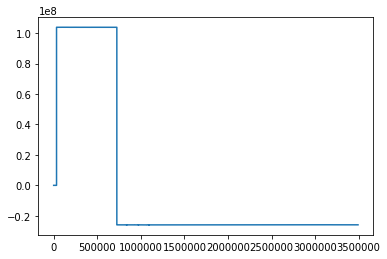

In [26]:
plt.plot(sub)
plt.show()